In [1]:
!pip install vit-pytorch linformer

Loading Libraries

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   

Import Linformer

In [3]:
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function

Import Torch related Packages

In [4]:
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset

#to unzip the datasets
import zipfile   

In [5]:
#sklearn to split the data

from sklearn.model_selection import train_test_split

In [6]:
#definining batch size, epocs, learning rate and gamma for training  

batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [8]:

# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cp -rf '/content/drive/MyDrive/train.zip' .

In [12]:
#Load data

os.makedirs('data', exist_ok=True)
train_dir = 'data/train'
test_dir = 'data/test'

#Unzipping dataset
with zipfile.ZipFile('train.zip') as train_zip:
    train_zip.extractall('data')
    
with zipfile.ZipFile('test.zip') as test_zip:
    test_zip.extractall('data')

#Creating train and test list 

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

#printing length of the dataset

print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [13]:
#Defining labels

labels = [path.split('/')[-1].split('.')[0] for path in train_list]

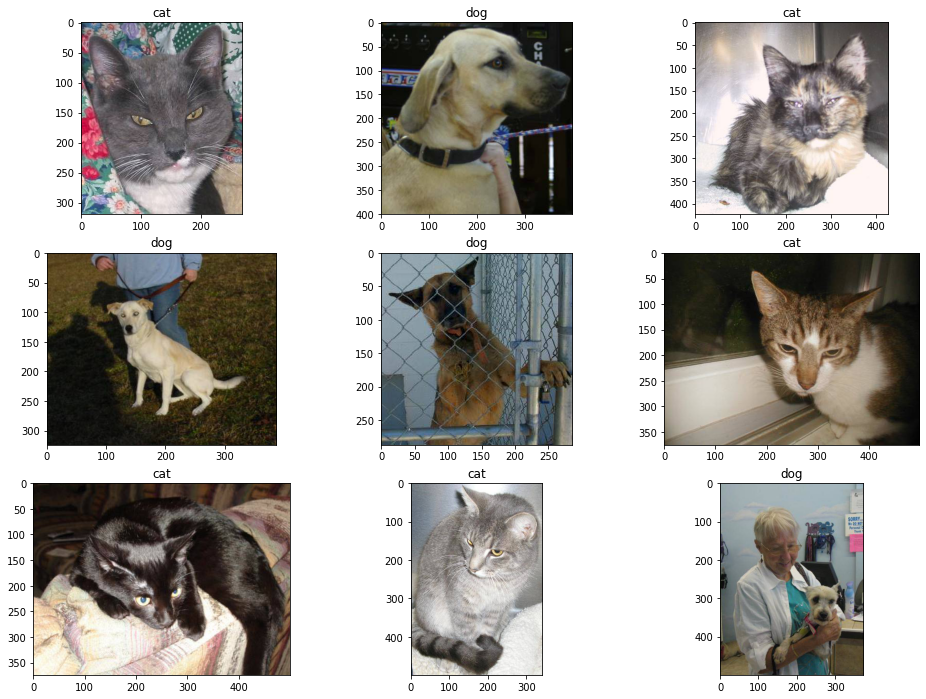

In [14]:
# printing few images 

random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [16]:
#Splitting train and validation list

train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=42)
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [18]:

# Torch transforms

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [20]:
#Loading dataset for training 

class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [21]:
#defining train, validation and test dataset
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [22]:
#loading dataloader

train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [23]:
#Line transformer 

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [25]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")    

In [26]:
#Visual transformer 

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [27]:
# loss function
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)


In [28]:
#start training

for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.6957 - acc: 0.5072 - val_loss : 0.6930 - val_acc: 0.5014




Epoch : 2 - loss : 0.6898 - acc: 0.5350 - val_loss : 0.6914 - val_acc: 0.5295




Epoch : 3 - loss : 0.6833 - acc: 0.5541 - val_loss : 0.6813 - val_acc: 0.5692




Epoch : 4 - loss : 0.6778 - acc: 0.5705 - val_loss : 0.6738 - val_acc: 0.5795




Epoch : 5 - loss : 0.6733 - acc: 0.5793 - val_loss : 0.6723 - val_acc: 0.5674




Epoch : 6 - loss : 0.6649 - acc: 0.5918 - val_loss : 0.6669 - val_acc: 0.5916




Epoch : 7 - loss : 0.6554 - acc: 0.6034 - val_loss : 0.6537 - val_acc: 0.6050




Epoch : 8 - loss : 0.6468 - acc: 0.6155 - val_loss : 0.6538 - val_acc: 0.5918




Epoch : 9 - loss : 0.6401 - acc: 0.6210 - val_loss : 0.6405 - val_acc: 0.6179




Epoch : 10 - loss : 0.6307 - acc: 0.6364 - val_loss : 0.6309 - val_acc: 0.6280




Epoch : 11 - loss : 0.6246 - acc: 0.6418 - val_loss : 0.6241 - val_acc: 0.6392




Epoch : 12 - loss : 0.6222 - acc: 0.6425 - val_loss : 0.6312 - val_acc: 0.6361




Epoch : 13 - loss : 0.6163 - acc: 0.6522 - val_loss : 0.6234 - val_acc: 0.6472




Epoch : 14 - loss : 0.6076 - acc: 0.6617 - val_loss : 0.6004 - val_acc: 0.6652




Epoch : 15 - loss : 0.6064 - acc: 0.6628 - val_loss : 0.6075 - val_acc: 0.6580




Epoch : 16 - loss : 0.5969 - acc: 0.6718 - val_loss : 0.5903 - val_acc: 0.6831




Epoch : 17 - loss : 0.5948 - acc: 0.6731 - val_loss : 0.5872 - val_acc: 0.6822




Epoch : 18 - loss : 0.5899 - acc: 0.6763 - val_loss : 0.5904 - val_acc: 0.6830




Epoch : 19 - loss : 0.5890 - acc: 0.6770 - val_loss : 0.5878 - val_acc: 0.6883




Epoch : 20 - loss : 0.5873 - acc: 0.6783 - val_loss : 0.5963 - val_acc: 0.6750

